[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-1-3976126566.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.classes_, y=f1_scores, palette="viridis")


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d88166e1a5dc7f7c4d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


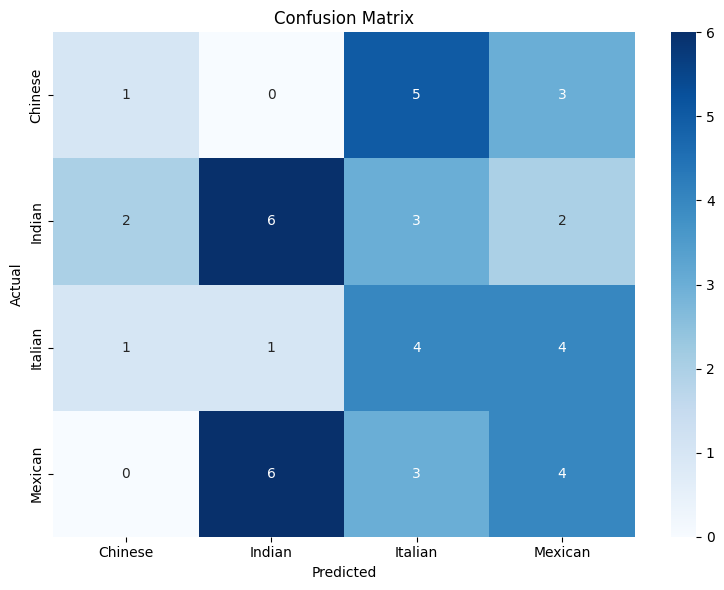

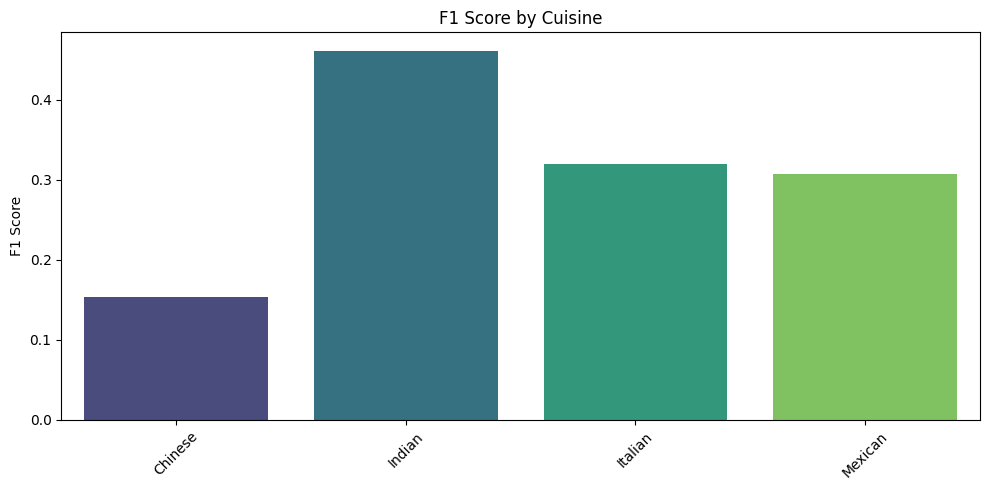

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import joblib
import csv
import gradio as gr
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

# Download stopwords
nltk.download("stopwords")
stop_words = set(nltk.corpus.stopwords.words("english"))

# Load cleaned data
data = pd.read_csv("13k-recipes-cleaned.csv", on_bad_lines='skip', quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python')
data = data.dropna(subset=["ingredients"])

# Add a fallback cuisine_path column if missing
if "cuisine_path" not in data.columns:
    data["cuisine_path"] = np.random.choice(["Italian", "Indian", "Mexican", "Chinese"], size=len(data))

# Preprocessing
def preprocess_ingredients(ingredients):
    if isinstance(ingredients, list):
        text = ' '.join(ingredients)
    elif isinstance(ingredients, str):
        text = ingredients
    else:
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data["cleaned_ingredients"] = data["ingredients"].apply(preprocess_ingredients)

# Label encoding
le = preprocessing.LabelEncoder()
data["cuisine_encoded"] = le.fit_transform(data["cuisine_path"])

# Vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["cleaned_ingredients"])
y = data["cuisine_encoded"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = MultinomialNB()
model.fit(X_train, y_train)

# Save for later use
joblib.dump(model, "model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

# Prediction function
def predict_cuisine(ingredients):
    processed = preprocess_ingredients(ingredients)
    X_input = vectorizer.transform([processed])
    pred_class = model.predict(X_input)[0]
    return f"🍽️ Predicted Cuisine: **{le.inverse_transform([pred_class])[0]}**"

# Confusion Matrix Plot function
def generate_cm_plot():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("cm_plot.png")
    return "cm_plot.png"

# Accuracy Chart Plot
def generate_accuracy_plot():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    f1_scores = [report[cls]["f1-score"] for cls in le.classes_]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=le.classes_, y=f1_scores, palette="viridis")
    plt.ylabel("F1 Score")
    plt.title("F1 Score by Cuisine")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("accuracy_plot.png")
    return "accuracy_plot.png"

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# 🍳 Cuisine Classifier with Visualizations")

    with gr.Row():
        with gr.Column():
            inp = gr.Textbox(lines=3, label="Enter ingredients")
            predict_btn = gr.Button("Predict Cuisine")
            out = gr.Markdown()

        with gr.Column():
            gr.Markdown("### Confusion Matrix")
            cm_img = gr.Image(value=generate_cm_plot(), label="Confusion Matrix")

            gr.Markdown("### F1 Score Chart")
            acc_img = gr.Image(value=generate_accuracy_plot(), label="F1 Score by Class")

    predict_btn.click(predict_cuisine, inp, out)

demo.launch()
